# GAN для генерации рукописных цифр (MNIST) с использованием PyTorch

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [6]:
class StyleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.noise_scale = nn.Parameter(torch.zeros(1))
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x, 0.2)

        noise = torch.randn(x.size(0), 1, x.size(2), x.size(3), device=x.device)
        x = x + self.noise_scale * noise

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, 0.2)
        return x

class Generator(nn.Module):
    def __init__(self, z_dim=128, channels=28):
        super().__init__()
        self.initial = nn.Linear(z_dim, 7*7*channels)
        self.blocks = nn.ModuleList([
            StyleBlock(channels, channels//2),
            StyleBlock(channels//2, channels//4)
        ])
        self.final_conv = nn.Conv2d(channels//4, 1, 3, 1, 1)
        self.z_dim = z_dim

    def forward(self, z):
        # z: [batch, z_dim]
        x = self.initial(z).view(z.size(0), -1, 7, 7)

        for block in self.blocks:
            x = block(x)

        x = self.final_conv(x)
        x = torch.tanh(x)
        return x


In [7]:
class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.downsample = nn.AvgPool2d(2)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x, 0.2)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, 0.2)

        return self.downsample(x)

class Discriminator(nn.Module):
    def __init__(self, channels=28):
        super().__init__()
        self.blocks = nn.ModuleList([
            DiscriminatorBlock(1, channels//4),
            DiscriminatorBlock(channels//4, channels//2),
            DiscriminatorBlock(channels//2, channels)
        ])
        self.final = nn.Linear(channels*3*3, 1)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)

        x = x.view(x.size(0), -1)
        return self.final(x)


In [8]:
# Функция для генерации и сохранения примеров
def generate_and_save_images(model, epoch, noise):
    model.eval() # Переводим модель в режим оценки
    with torch.no_grad():  # Отключаем вычисление градиентов
        fake_images = model(noise).cpu()
        fake_images = fake_images.view(fake_images.size(0), 28, 28)

        # Создаем сетку изображений
        plt.figure(figsize=(4, 4))
        for i in range(fake_images.size(0)):
            plt.subplot(4, 4, i+1)
            plt.imshow(fake_images[i], cmap='gray')
            plt.axis('off')

        plt.savefig(f'gan/image_at_epoch_{epoch+1:04d}.png')
        plt.show()

In [10]:
NOISE_DIM = 100
NUM_EPOCHS = 100
BATCH_SIZE = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Преобразования для входных данных
transform = transforms.Compose([
    transforms.ToTensor(), # Конвертация в тензор
    transforms.Normalize((0.5,), (0.5,)) # Нормализация в диапазон [-1, 1]
])

# Загрузка данных MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
gen = Generator(NOISE_DIM).to(device)
disc = Discriminator().to(device)
opt_gen = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCEWithLogitsLoss()
test_noise = torch.randn(16, NOISE_DIM, device=device)

Epoch [1/100], Step [1/469], Discriminator Loss: 1.3553, Generator Loss: 0.6237
Epoch [1/100], Step [101/469], Discriminator Loss: 0.3962, Generator Loss: 2.2041
Epoch [1/100], Step [201/469], Discriminator Loss: 0.0833, Generator Loss: 3.7932
Epoch [1/100], Step [301/469], Discriminator Loss: 0.0861, Generator Loss: 4.0478
Epoch [1/100], Step [401/469], Discriminator Loss: 0.1080, Generator Loss: 3.8450


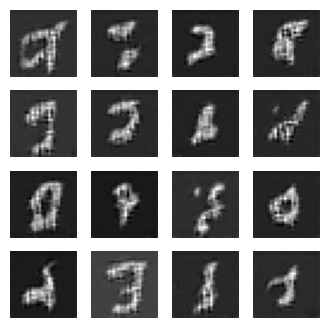

Epoch [2/100], Step [1/469], Discriminator Loss: 0.0765, Generator Loss: 4.2492
Epoch [2/100], Step [101/469], Discriminator Loss: 0.0975, Generator Loss: 3.9569
Epoch [2/100], Step [201/469], Discriminator Loss: 0.1236, Generator Loss: 3.8072
Epoch [2/100], Step [301/469], Discriminator Loss: 0.3500, Generator Loss: 2.1597
Epoch [2/100], Step [401/469], Discriminator Loss: 0.1233, Generator Loss: 3.6607


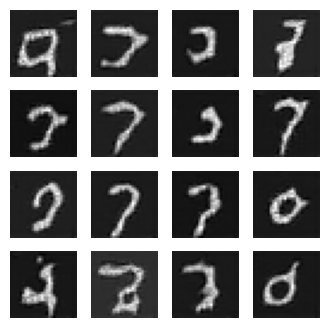

Epoch [3/100], Step [1/469], Discriminator Loss: 0.1563, Generator Loss: 3.0826
Epoch [3/100], Step [101/469], Discriminator Loss: 0.1384, Generator Loss: 3.3909
Epoch [3/100], Step [201/469], Discriminator Loss: 0.1711, Generator Loss: 4.4806
Epoch [3/100], Step [301/469], Discriminator Loss: 0.1019, Generator Loss: 4.2130
Epoch [3/100], Step [401/469], Discriminator Loss: 0.1028, Generator Loss: 3.4822


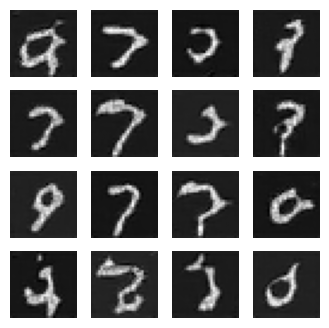

Epoch [4/100], Step [1/469], Discriminator Loss: 0.1330, Generator Loss: 4.1035
Epoch [4/100], Step [101/469], Discriminator Loss: 0.1335, Generator Loss: 3.7055
Epoch [4/100], Step [201/469], Discriminator Loss: 0.1462, Generator Loss: 3.9263
Epoch [4/100], Step [301/469], Discriminator Loss: 0.1340, Generator Loss: 3.5213
Epoch [4/100], Step [401/469], Discriminator Loss: 0.0840, Generator Loss: 4.1145


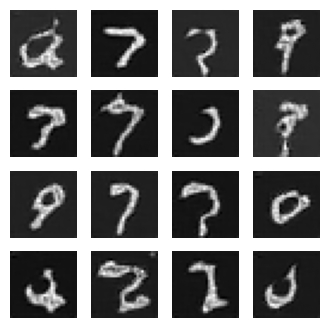

Epoch [5/100], Step [1/469], Discriminator Loss: 0.2132, Generator Loss: 2.2448
Epoch [5/100], Step [101/469], Discriminator Loss: 0.0752, Generator Loss: 3.8731
Epoch [5/100], Step [201/469], Discriminator Loss: 0.1143, Generator Loss: 3.6186
Epoch [5/100], Step [301/469], Discriminator Loss: 0.0635, Generator Loss: 4.2832
Epoch [5/100], Step [401/469], Discriminator Loss: 0.1160, Generator Loss: 3.6490


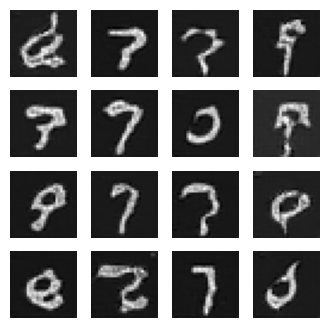

Epoch [6/100], Step [1/469], Discriminator Loss: 0.0811, Generator Loss: 4.2783
Epoch [6/100], Step [101/469], Discriminator Loss: 0.1486, Generator Loss: 3.3931
Epoch [6/100], Step [201/469], Discriminator Loss: 0.0649, Generator Loss: 3.7899
Epoch [6/100], Step [301/469], Discriminator Loss: 0.0913, Generator Loss: 4.8007
Epoch [6/100], Step [401/469], Discriminator Loss: 0.0879, Generator Loss: 4.4779


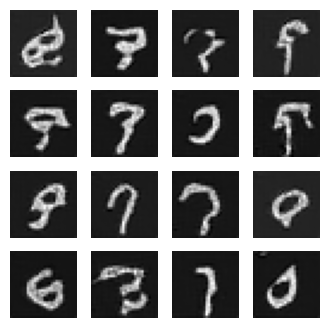

Epoch [7/100], Step [1/469], Discriminator Loss: 0.1129, Generator Loss: 3.7977
Epoch [7/100], Step [101/469], Discriminator Loss: 0.1014, Generator Loss: 3.5143
Epoch [7/100], Step [201/469], Discriminator Loss: 0.0553, Generator Loss: 4.2688
Epoch [7/100], Step [301/469], Discriminator Loss: 0.0938, Generator Loss: 4.0648
Epoch [7/100], Step [401/469], Discriminator Loss: 0.0829, Generator Loss: 3.8055


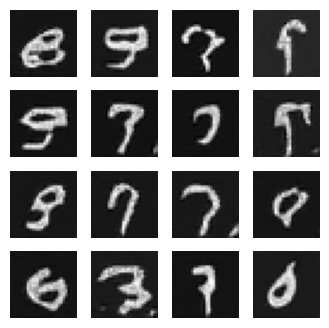

Epoch [8/100], Step [1/469], Discriminator Loss: 0.1036, Generator Loss: 3.9596
Epoch [8/100], Step [101/469], Discriminator Loss: 0.1000, Generator Loss: 4.0881
Epoch [8/100], Step [201/469], Discriminator Loss: 0.1170, Generator Loss: 3.8601
Epoch [8/100], Step [301/469], Discriminator Loss: 0.5682, Generator Loss: 7.8813
Epoch [8/100], Step [401/469], Discriminator Loss: 0.1038, Generator Loss: 4.2079


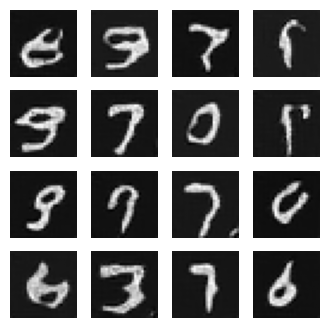

Epoch [9/100], Step [1/469], Discriminator Loss: 0.0694, Generator Loss: 4.4808
Epoch [9/100], Step [101/469], Discriminator Loss: 0.1501, Generator Loss: 2.8830
Epoch [9/100], Step [201/469], Discriminator Loss: 0.0577, Generator Loss: 3.7980
Epoch [9/100], Step [301/469], Discriminator Loss: 0.0995, Generator Loss: 4.1560
Epoch [9/100], Step [401/469], Discriminator Loss: 0.1782, Generator Loss: 2.9674


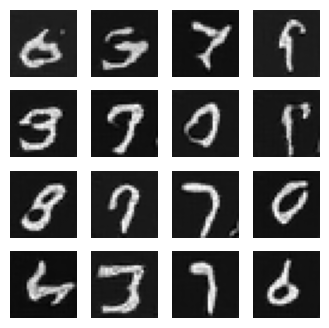

Epoch [10/100], Step [1/469], Discriminator Loss: 0.0720, Generator Loss: 4.2258
Epoch [10/100], Step [101/469], Discriminator Loss: 0.6857, Generator Loss: 3.2482
Epoch [10/100], Step [201/469], Discriminator Loss: 0.0566, Generator Loss: 5.5068
Epoch [10/100], Step [301/469], Discriminator Loss: 0.0433, Generator Loss: 4.4765
Epoch [10/100], Step [401/469], Discriminator Loss: 0.0652, Generator Loss: 4.7199


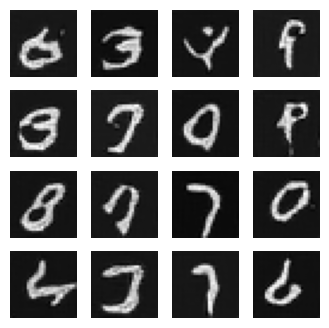

Epoch [11/100], Step [1/469], Discriminator Loss: 1.0992, Generator Loss: 10.1877
Epoch [11/100], Step [101/469], Discriminator Loss: 0.0787, Generator Loss: 4.1553
Epoch [11/100], Step [201/469], Discriminator Loss: 0.1376, Generator Loss: 4.2675
Epoch [11/100], Step [301/469], Discriminator Loss: 0.0873, Generator Loss: 4.2991
Epoch [11/100], Step [401/469], Discriminator Loss: 0.1239, Generator Loss: 4.6457


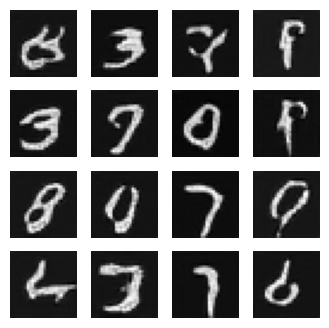

Epoch [12/100], Step [1/469], Discriminator Loss: 0.0583, Generator Loss: 4.3605
Epoch [12/100], Step [101/469], Discriminator Loss: 0.1556, Generator Loss: 2.6765
Epoch [12/100], Step [201/469], Discriminator Loss: 3.5261, Generator Loss: 3.3081
Epoch [12/100], Step [301/469], Discriminator Loss: 0.1028, Generator Loss: 4.5298
Epoch [12/100], Step [401/469], Discriminator Loss: 0.0804, Generator Loss: 4.1976


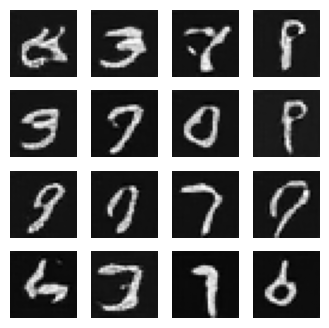

Epoch [13/100], Step [1/469], Discriminator Loss: 0.0718, Generator Loss: 4.7544
Epoch [13/100], Step [101/469], Discriminator Loss: 0.1639, Generator Loss: 4.8065
Epoch [13/100], Step [201/469], Discriminator Loss: 0.1042, Generator Loss: 4.3869
Epoch [13/100], Step [301/469], Discriminator Loss: 0.1238, Generator Loss: 3.9927
Epoch [13/100], Step [401/469], Discriminator Loss: 0.0665, Generator Loss: 4.1371


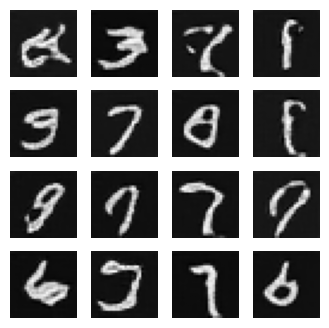

Epoch [14/100], Step [1/469], Discriminator Loss: 0.1720, Generator Loss: 3.3838
Epoch [14/100], Step [101/469], Discriminator Loss: 0.2843, Generator Loss: 4.1887
Epoch [14/100], Step [201/469], Discriminator Loss: 0.1679, Generator Loss: 5.4403
Epoch [14/100], Step [301/469], Discriminator Loss: 0.1355, Generator Loss: 5.0466
Epoch [14/100], Step [401/469], Discriminator Loss: 0.1226, Generator Loss: 3.7551


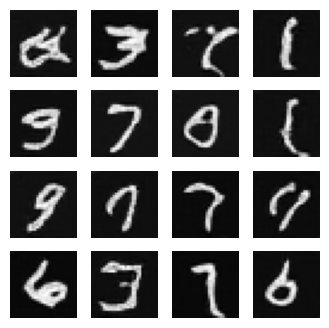

Epoch [15/100], Step [1/469], Discriminator Loss: 0.2748, Generator Loss: 3.8505
Epoch [15/100], Step [101/469], Discriminator Loss: 0.1484, Generator Loss: 3.6796
Epoch [15/100], Step [201/469], Discriminator Loss: 0.0772, Generator Loss: 4.0551
Epoch [15/100], Step [301/469], Discriminator Loss: 0.1845, Generator Loss: 3.6671
Epoch [15/100], Step [401/469], Discriminator Loss: 0.2769, Generator Loss: 2.1683


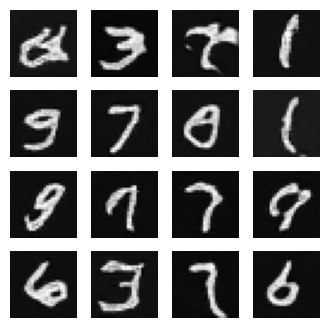

Epoch [16/100], Step [1/469], Discriminator Loss: 1.4274, Generator Loss: 0.5609
Epoch [16/100], Step [101/469], Discriminator Loss: 0.1326, Generator Loss: 3.0309
Epoch [16/100], Step [201/469], Discriminator Loss: 0.1551, Generator Loss: 3.1569
Epoch [16/100], Step [301/469], Discriminator Loss: 0.2035, Generator Loss: 3.9814
Epoch [16/100], Step [401/469], Discriminator Loss: 0.2292, Generator Loss: 2.4646


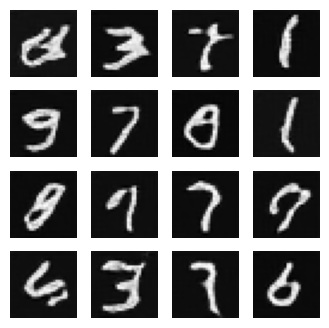

Epoch [17/100], Step [1/469], Discriminator Loss: 0.2229, Generator Loss: 3.6387
Epoch [17/100], Step [101/469], Discriminator Loss: 0.2530, Generator Loss: 3.9421
Epoch [17/100], Step [201/469], Discriminator Loss: 0.3556, Generator Loss: 2.3189
Epoch [17/100], Step [301/469], Discriminator Loss: 0.1337, Generator Loss: 3.2686
Epoch [17/100], Step [401/469], Discriminator Loss: 0.4639, Generator Loss: 2.2174


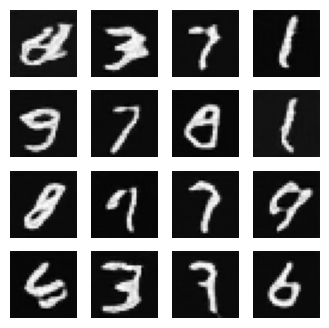

Epoch [18/100], Step [1/469], Discriminator Loss: 0.1416, Generator Loss: 3.0087
Epoch [18/100], Step [101/469], Discriminator Loss: 0.3201, Generator Loss: 3.2543
Epoch [18/100], Step [201/469], Discriminator Loss: 0.1815, Generator Loss: 3.4418
Epoch [18/100], Step [301/469], Discriminator Loss: 0.0982, Generator Loss: 3.9627
Epoch [18/100], Step [401/469], Discriminator Loss: 0.3354, Generator Loss: 1.7584


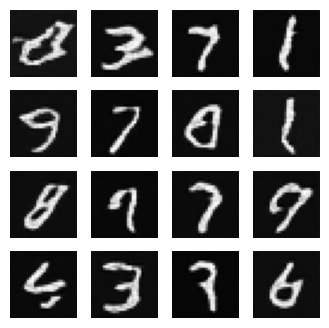

Epoch [19/100], Step [1/469], Discriminator Loss: 0.3613, Generator Loss: 3.0543
Epoch [19/100], Step [101/469], Discriminator Loss: 0.1971, Generator Loss: 3.1105
Epoch [19/100], Step [201/469], Discriminator Loss: 0.1270, Generator Loss: 3.6809
Epoch [19/100], Step [301/469], Discriminator Loss: 0.1683, Generator Loss: 3.3582
Epoch [19/100], Step [401/469], Discriminator Loss: 0.1470, Generator Loss: 3.9174


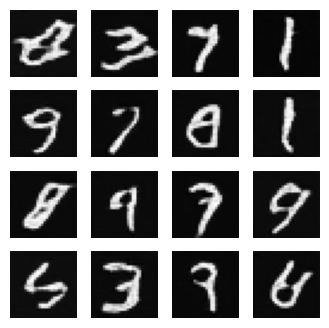

Epoch [20/100], Step [1/469], Discriminator Loss: 0.1788, Generator Loss: 3.3732
Epoch [20/100], Step [101/469], Discriminator Loss: 0.2035, Generator Loss: 2.9930
Epoch [20/100], Step [201/469], Discriminator Loss: 0.1323, Generator Loss: 3.7052
Epoch [20/100], Step [301/469], Discriminator Loss: 0.3419, Generator Loss: 2.8430
Epoch [20/100], Step [401/469], Discriminator Loss: 0.1961, Generator Loss: 2.2584


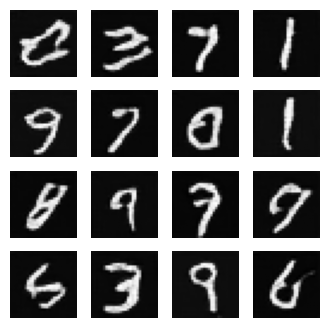

Epoch [21/100], Step [1/469], Discriminator Loss: 0.2289, Generator Loss: 3.4771
Epoch [21/100], Step [101/469], Discriminator Loss: 0.1267, Generator Loss: 4.0609
Epoch [21/100], Step [201/469], Discriminator Loss: 0.1361, Generator Loss: 3.8085
Epoch [21/100], Step [301/469], Discriminator Loss: 0.1533, Generator Loss: 2.9688
Epoch [21/100], Step [401/469], Discriminator Loss: 0.3108, Generator Loss: 3.0992


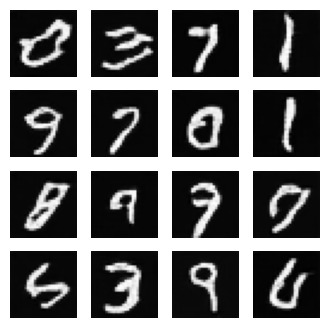

Epoch [22/100], Step [1/469], Discriminator Loss: 0.0724, Generator Loss: 3.4699
Epoch [22/100], Step [101/469], Discriminator Loss: 0.1117, Generator Loss: 4.4691
Epoch [22/100], Step [201/469], Discriminator Loss: 0.1367, Generator Loss: 3.8577
Epoch [22/100], Step [301/469], Discriminator Loss: 0.1482, Generator Loss: 4.2946
Epoch [22/100], Step [401/469], Discriminator Loss: 0.4544, Generator Loss: 5.1990


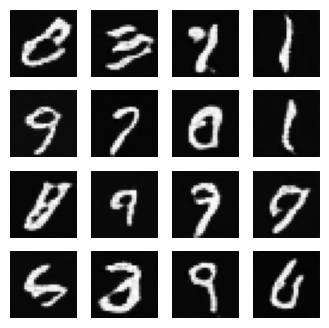

Epoch [23/100], Step [1/469], Discriminator Loss: 0.1623, Generator Loss: 3.7474
Epoch [23/100], Step [101/469], Discriminator Loss: 0.8990, Generator Loss: 2.2530
Epoch [23/100], Step [201/469], Discriminator Loss: 0.1937, Generator Loss: 3.1847
Epoch [23/100], Step [301/469], Discriminator Loss: 0.1994, Generator Loss: 2.6922
Epoch [23/100], Step [401/469], Discriminator Loss: 0.0696, Generator Loss: 3.8204


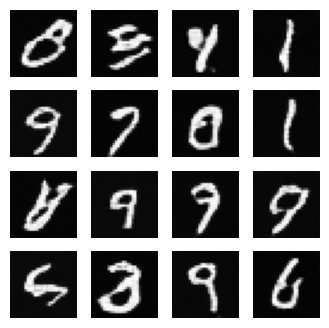

Epoch [24/100], Step [1/469], Discriminator Loss: 0.1657, Generator Loss: 3.8771
Epoch [24/100], Step [101/469], Discriminator Loss: 0.1204, Generator Loss: 4.3441
Epoch [24/100], Step [201/469], Discriminator Loss: 0.1220, Generator Loss: 3.8887
Epoch [24/100], Step [301/469], Discriminator Loss: 0.3656, Generator Loss: 3.9345
Epoch [24/100], Step [401/469], Discriminator Loss: 0.1745, Generator Loss: 3.3629


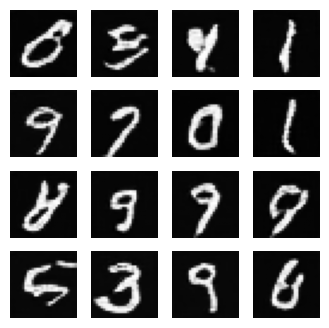

Epoch [25/100], Step [1/469], Discriminator Loss: 0.2461, Generator Loss: 3.4194
Epoch [25/100], Step [101/469], Discriminator Loss: 0.1336, Generator Loss: 3.6055
Epoch [25/100], Step [201/469], Discriminator Loss: 0.1432, Generator Loss: 3.6121
Epoch [25/100], Step [301/469], Discriminator Loss: 0.1503, Generator Loss: 3.2441
Epoch [25/100], Step [401/469], Discriminator Loss: 0.1901, Generator Loss: 3.4388


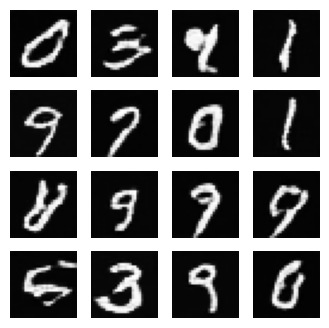

Epoch [26/100], Step [1/469], Discriminator Loss: 0.1595, Generator Loss: 4.1311
Epoch [26/100], Step [101/469], Discriminator Loss: 0.2006, Generator Loss: 3.1103
Epoch [26/100], Step [201/469], Discriminator Loss: 0.3308, Generator Loss: 1.9223
Epoch [26/100], Step [301/469], Discriminator Loss: 0.2141, Generator Loss: 2.9977
Epoch [26/100], Step [401/469], Discriminator Loss: 0.2252, Generator Loss: 3.6122


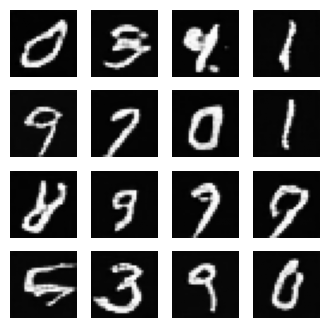

Epoch [27/100], Step [1/469], Discriminator Loss: 0.3217, Generator Loss: 3.3165
Epoch [27/100], Step [101/469], Discriminator Loss: 0.0861, Generator Loss: 4.3485
Epoch [27/100], Step [201/469], Discriminator Loss: 0.2950, Generator Loss: 2.1837
Epoch [27/100], Step [301/469], Discriminator Loss: 0.3489, Generator Loss: 1.4418
Epoch [27/100], Step [401/469], Discriminator Loss: 0.1805, Generator Loss: 3.3842


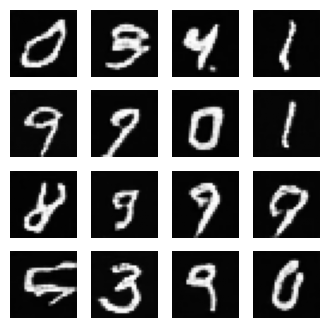

Epoch [28/100], Step [1/469], Discriminator Loss: 0.1591, Generator Loss: 2.9554
Epoch [28/100], Step [101/469], Discriminator Loss: 0.1433, Generator Loss: 3.3155
Epoch [28/100], Step [201/469], Discriminator Loss: 0.2032, Generator Loss: 3.4992
Epoch [28/100], Step [301/469], Discriminator Loss: 0.2093, Generator Loss: 3.5615
Epoch [28/100], Step [401/469], Discriminator Loss: 0.1279, Generator Loss: 3.4619


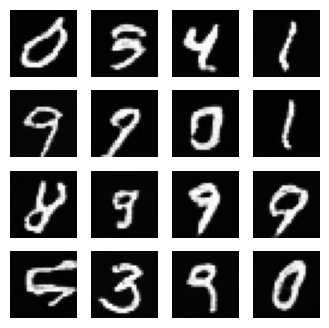

Epoch [29/100], Step [1/469], Discriminator Loss: 0.1354, Generator Loss: 3.4795
Epoch [29/100], Step [101/469], Discriminator Loss: 0.3037, Generator Loss: 3.6784
Epoch [29/100], Step [201/469], Discriminator Loss: 0.1646, Generator Loss: 3.5548
Epoch [29/100], Step [301/469], Discriminator Loss: 0.1891, Generator Loss: 4.9153
Epoch [29/100], Step [401/469], Discriminator Loss: 0.2295, Generator Loss: 2.1466


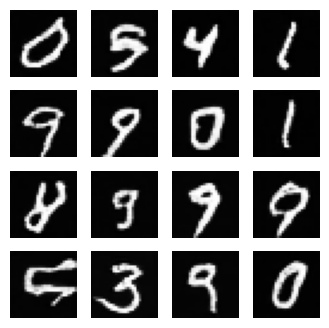

Epoch [30/100], Step [1/469], Discriminator Loss: 0.0966, Generator Loss: 4.0239
Epoch [30/100], Step [101/469], Discriminator Loss: 0.1555, Generator Loss: 3.4551
Epoch [30/100], Step [201/469], Discriminator Loss: 0.3830, Generator Loss: 4.1934
Epoch [30/100], Step [301/469], Discriminator Loss: 0.1112, Generator Loss: 4.4821
Epoch [30/100], Step [401/469], Discriminator Loss: 0.2378, Generator Loss: 3.4345


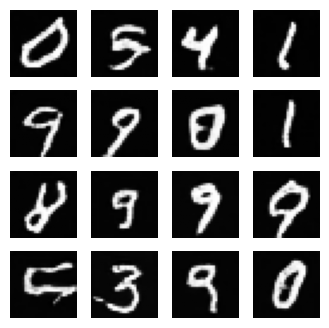

Epoch [31/100], Step [1/469], Discriminator Loss: 0.8856, Generator Loss: 5.8586
Epoch [31/100], Step [101/469], Discriminator Loss: 0.1481, Generator Loss: 3.2477
Epoch [31/100], Step [201/469], Discriminator Loss: 0.1539, Generator Loss: 3.5951
Epoch [31/100], Step [301/469], Discriminator Loss: 0.2865, Generator Loss: 3.8706
Epoch [31/100], Step [401/469], Discriminator Loss: 0.5246, Generator Loss: 4.3694


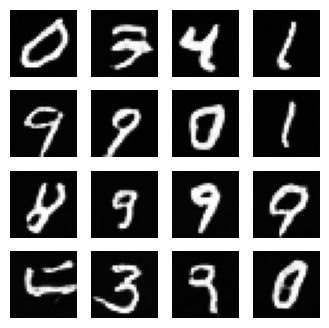

Epoch [32/100], Step [1/469], Discriminator Loss: 0.2141, Generator Loss: 3.0696
Epoch [32/100], Step [101/469], Discriminator Loss: 0.5048, Generator Loss: 4.4444
Epoch [32/100], Step [201/469], Discriminator Loss: 0.1068, Generator Loss: 3.2498
Epoch [32/100], Step [301/469], Discriminator Loss: 0.1699, Generator Loss: 2.9921
Epoch [32/100], Step [401/469], Discriminator Loss: 0.2261, Generator Loss: 4.1537


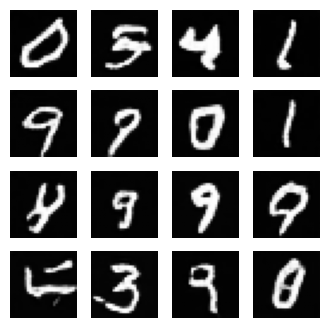

Epoch [33/100], Step [1/469], Discriminator Loss: 0.1729, Generator Loss: 3.6205
Epoch [33/100], Step [101/469], Discriminator Loss: 0.3584, Generator Loss: 4.0966
Epoch [33/100], Step [201/469], Discriminator Loss: 0.5324, Generator Loss: 6.4131
Epoch [33/100], Step [301/469], Discriminator Loss: 0.4328, Generator Loss: 4.1709
Epoch [33/100], Step [401/469], Discriminator Loss: 0.1287, Generator Loss: 3.5562


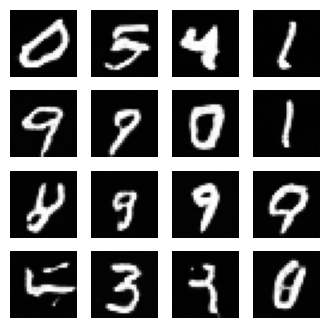

Epoch [34/100], Step [1/469], Discriminator Loss: 0.8967, Generator Loss: 5.3769
Epoch [34/100], Step [101/469], Discriminator Loss: 0.1230, Generator Loss: 3.7979
Epoch [34/100], Step [201/469], Discriminator Loss: 0.1610, Generator Loss: 3.0780
Epoch [34/100], Step [301/469], Discriminator Loss: 0.2005, Generator Loss: 3.5738
Epoch [34/100], Step [401/469], Discriminator Loss: 0.5684, Generator Loss: 4.1287


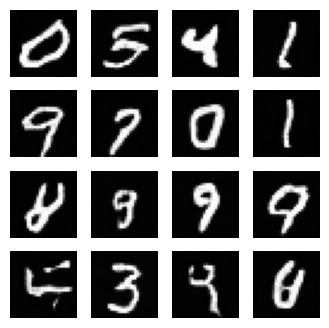

Epoch [35/100], Step [1/469], Discriminator Loss: 0.1960, Generator Loss: 2.7411
Epoch [35/100], Step [101/469], Discriminator Loss: 0.0802, Generator Loss: 3.8896
Epoch [35/100], Step [201/469], Discriminator Loss: 0.2364, Generator Loss: 3.7307
Epoch [35/100], Step [301/469], Discriminator Loss: 0.1765, Generator Loss: 3.7298
Epoch [35/100], Step [401/469], Discriminator Loss: 0.3483, Generator Loss: 3.3065


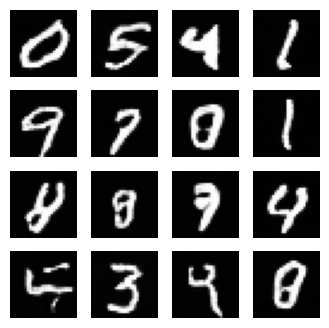

Epoch [36/100], Step [1/469], Discriminator Loss: 0.1752, Generator Loss: 3.4435
Epoch [36/100], Step [101/469], Discriminator Loss: 0.1138, Generator Loss: 3.3073
Epoch [36/100], Step [201/469], Discriminator Loss: 0.3516, Generator Loss: 3.7032
Epoch [36/100], Step [301/469], Discriminator Loss: 0.0830, Generator Loss: 6.3879
Epoch [36/100], Step [401/469], Discriminator Loss: 0.3129, Generator Loss: 4.6131


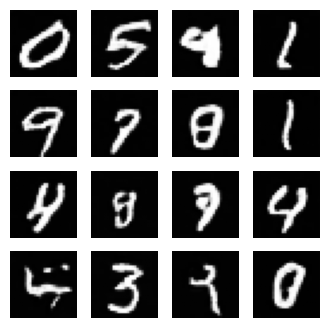

Epoch [37/100], Step [1/469], Discriminator Loss: 0.2291, Generator Loss: 4.3302
Epoch [37/100], Step [101/469], Discriminator Loss: 0.1971, Generator Loss: 5.2919
Epoch [37/100], Step [201/469], Discriminator Loss: 0.4973, Generator Loss: 0.7794
Epoch [37/100], Step [301/469], Discriminator Loss: 0.0478, Generator Loss: 3.9137
Epoch [37/100], Step [401/469], Discriminator Loss: 0.0714, Generator Loss: 3.2834


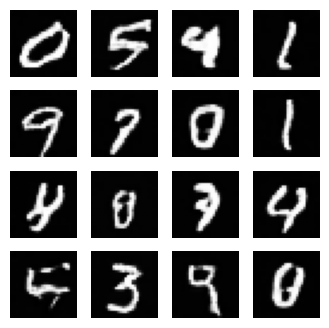

Epoch [38/100], Step [1/469], Discriminator Loss: 0.4187, Generator Loss: 6.3863
Epoch [38/100], Step [101/469], Discriminator Loss: 0.2984, Generator Loss: 2.5395
Epoch [38/100], Step [201/469], Discriminator Loss: 0.2436, Generator Loss: 2.4742
Epoch [38/100], Step [301/469], Discriminator Loss: 0.2852, Generator Loss: 4.7374
Epoch [38/100], Step [401/469], Discriminator Loss: 0.2411, Generator Loss: 3.9464


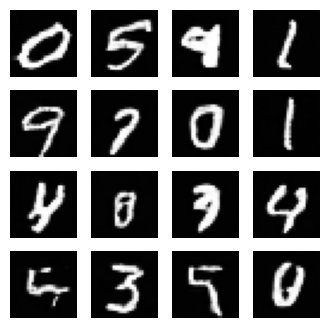

Epoch [39/100], Step [1/469], Discriminator Loss: 0.1840, Generator Loss: 2.5214
Epoch [39/100], Step [101/469], Discriminator Loss: 0.1677, Generator Loss: 3.7064
Epoch [39/100], Step [201/469], Discriminator Loss: 0.1205, Generator Loss: 3.3910
Epoch [39/100], Step [301/469], Discriminator Loss: 0.2730, Generator Loss: 3.3038
Epoch [39/100], Step [401/469], Discriminator Loss: 0.0761, Generator Loss: 3.9137


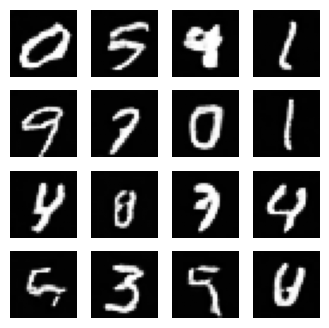

Epoch [40/100], Step [1/469], Discriminator Loss: 0.1080, Generator Loss: 3.1383
Epoch [40/100], Step [101/469], Discriminator Loss: 0.1615, Generator Loss: 5.1078
Epoch [40/100], Step [201/469], Discriminator Loss: 0.8601, Generator Loss: 2.2694
Epoch [40/100], Step [301/469], Discriminator Loss: 1.9454, Generator Loss: 1.2665
Epoch [40/100], Step [401/469], Discriminator Loss: 0.2139, Generator Loss: 2.3586


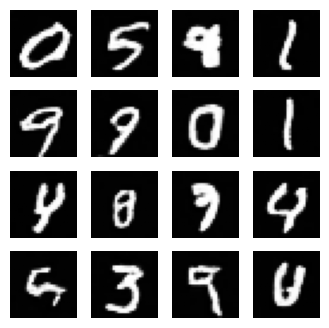

Epoch [41/100], Step [1/469], Discriminator Loss: 0.1361, Generator Loss: 6.0102
Epoch [41/100], Step [101/469], Discriminator Loss: 0.1996, Generator Loss: 4.2557
Epoch [41/100], Step [201/469], Discriminator Loss: 0.0663, Generator Loss: 4.3156
Epoch [41/100], Step [301/469], Discriminator Loss: 0.0617, Generator Loss: 4.2332
Epoch [41/100], Step [401/469], Discriminator Loss: 0.1473, Generator Loss: 3.7016


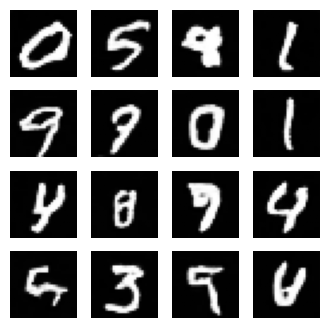

Epoch [42/100], Step [1/469], Discriminator Loss: 0.1041, Generator Loss: 4.8384
Epoch [42/100], Step [101/469], Discriminator Loss: 0.1377, Generator Loss: 3.7493
Epoch [42/100], Step [201/469], Discriminator Loss: 0.2983, Generator Loss: 5.0582
Epoch [42/100], Step [301/469], Discriminator Loss: 0.0900, Generator Loss: 4.5308
Epoch [42/100], Step [401/469], Discriminator Loss: 0.2838, Generator Loss: 1.6952


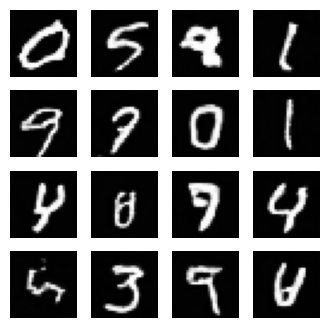

Epoch [43/100], Step [1/469], Discriminator Loss: 0.2662, Generator Loss: 3.6540
Epoch [43/100], Step [101/469], Discriminator Loss: 0.4025, Generator Loss: 3.5800
Epoch [43/100], Step [201/469], Discriminator Loss: 0.0629, Generator Loss: 4.5796
Epoch [43/100], Step [301/469], Discriminator Loss: 0.1397, Generator Loss: 3.7559
Epoch [43/100], Step [401/469], Discriminator Loss: 0.0923, Generator Loss: 5.6545


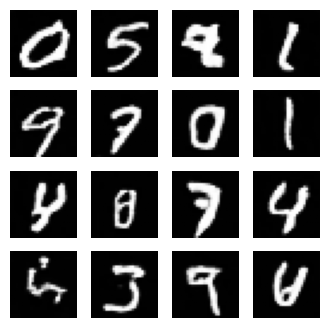

Epoch [44/100], Step [1/469], Discriminator Loss: 1.5083, Generator Loss: 8.9728
Epoch [44/100], Step [101/469], Discriminator Loss: 0.1105, Generator Loss: 3.2530
Epoch [44/100], Step [201/469], Discriminator Loss: 0.1214, Generator Loss: 4.4278
Epoch [44/100], Step [301/469], Discriminator Loss: 0.1599, Generator Loss: 2.9971
Epoch [44/100], Step [401/469], Discriminator Loss: 0.2158, Generator Loss: 3.5497


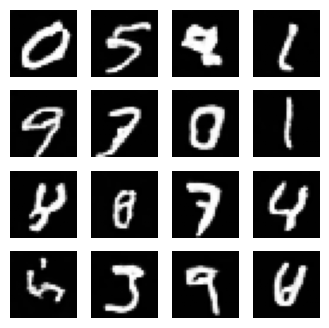

Epoch [45/100], Step [1/469], Discriminator Loss: 0.0786, Generator Loss: 4.5678
Epoch [45/100], Step [101/469], Discriminator Loss: 0.6432, Generator Loss: 4.8707
Epoch [45/100], Step [201/469], Discriminator Loss: 0.0733, Generator Loss: 4.3686
Epoch [45/100], Step [301/469], Discriminator Loss: 0.1455, Generator Loss: 3.9139
Epoch [45/100], Step [401/469], Discriminator Loss: 0.1999, Generator Loss: 4.5371


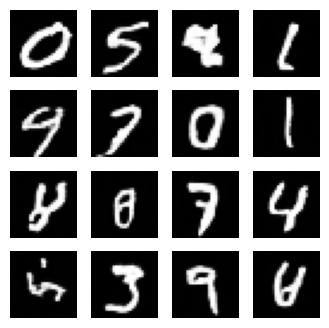

Epoch [46/100], Step [1/469], Discriminator Loss: 0.0365, Generator Loss: 5.0044
Epoch [46/100], Step [101/469], Discriminator Loss: 0.7460, Generator Loss: 8.4312
Epoch [46/100], Step [201/469], Discriminator Loss: 0.1101, Generator Loss: 4.4857
Epoch [46/100], Step [301/469], Discriminator Loss: 0.0782, Generator Loss: 3.9172
Epoch [46/100], Step [401/469], Discriminator Loss: 0.1480, Generator Loss: 3.8936


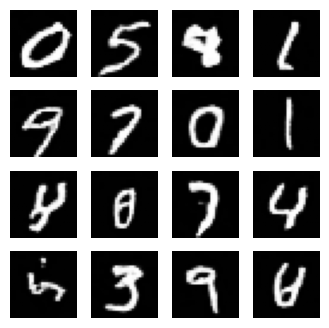

Epoch [47/100], Step [1/469], Discriminator Loss: 0.3587, Generator Loss: 2.6429
Epoch [47/100], Step [101/469], Discriminator Loss: 1.0156, Generator Loss: 3.5049
Epoch [47/100], Step [201/469], Discriminator Loss: 0.2750, Generator Loss: 3.3616
Epoch [47/100], Step [301/469], Discriminator Loss: 0.2238, Generator Loss: 4.0222
Epoch [47/100], Step [401/469], Discriminator Loss: 0.2194, Generator Loss: 3.4190


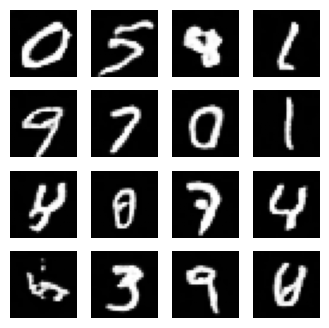

Epoch [48/100], Step [1/469], Discriminator Loss: 0.2148, Generator Loss: 2.8149
Epoch [48/100], Step [101/469], Discriminator Loss: 0.0873, Generator Loss: 4.9945
Epoch [48/100], Step [201/469], Discriminator Loss: 0.1163, Generator Loss: 4.3441
Epoch [48/100], Step [301/469], Discriminator Loss: 0.1223, Generator Loss: 3.0830
Epoch [48/100], Step [401/469], Discriminator Loss: 0.0594, Generator Loss: 4.5596


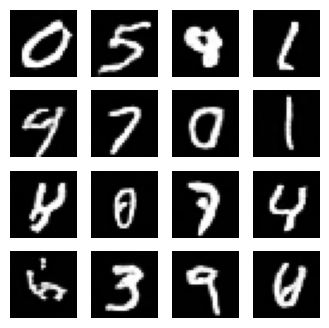

Epoch [49/100], Step [1/469], Discriminator Loss: 0.0995, Generator Loss: 4.8946
Epoch [49/100], Step [101/469], Discriminator Loss: 0.1236, Generator Loss: 3.8999
Epoch [49/100], Step [201/469], Discriminator Loss: 0.2018, Generator Loss: 3.4959
Epoch [49/100], Step [301/469], Discriminator Loss: 0.1058, Generator Loss: 4.3967
Epoch [49/100], Step [401/469], Discriminator Loss: 0.2031, Generator Loss: 3.8526


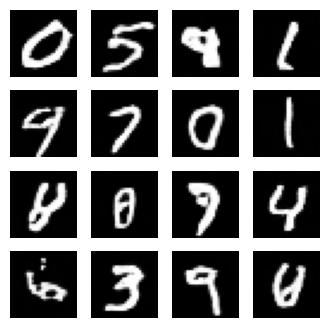

Epoch [50/100], Step [1/469], Discriminator Loss: 0.0567, Generator Loss: 4.4494
Epoch [50/100], Step [101/469], Discriminator Loss: 0.3570, Generator Loss: 5.9295
Epoch [50/100], Step [201/469], Discriminator Loss: 0.6831, Generator Loss: 1.6823
Epoch [50/100], Step [301/469], Discriminator Loss: 0.1163, Generator Loss: 3.8835
Epoch [50/100], Step [401/469], Discriminator Loss: 0.5150, Generator Loss: 6.4002


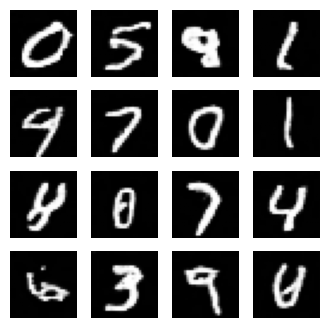

Epoch [51/100], Step [1/469], Discriminator Loss: 0.2573, Generator Loss: 3.3981
Epoch [51/100], Step [101/469], Discriminator Loss: 0.0695, Generator Loss: 4.5460
Epoch [51/100], Step [201/469], Discriminator Loss: 0.0236, Generator Loss: 5.8579
Epoch [51/100], Step [301/469], Discriminator Loss: 0.1946, Generator Loss: 2.9962
Epoch [51/100], Step [401/469], Discriminator Loss: 0.0970, Generator Loss: 4.6175


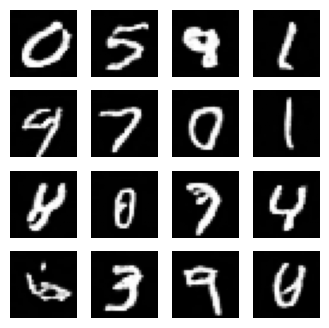

Epoch [52/100], Step [1/469], Discriminator Loss: 0.1573, Generator Loss: 4.4217
Epoch [52/100], Step [101/469], Discriminator Loss: 0.1585, Generator Loss: 4.7963
Epoch [52/100], Step [201/469], Discriminator Loss: 0.1293, Generator Loss: 4.3495
Epoch [52/100], Step [301/469], Discriminator Loss: 0.1188, Generator Loss: 4.2787
Epoch [52/100], Step [401/469], Discriminator Loss: 0.1166, Generator Loss: 4.2583


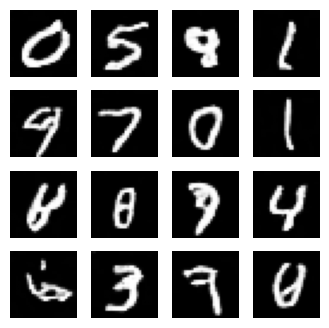

Epoch [53/100], Step [1/469], Discriminator Loss: 0.2768, Generator Loss: 5.0833
Epoch [53/100], Step [101/469], Discriminator Loss: 0.0391, Generator Loss: 4.4947
Epoch [53/100], Step [201/469], Discriminator Loss: 0.1723, Generator Loss: 6.2082
Epoch [53/100], Step [301/469], Discriminator Loss: 0.1461, Generator Loss: 3.2587
Epoch [53/100], Step [401/469], Discriminator Loss: 0.2318, Generator Loss: 5.0629


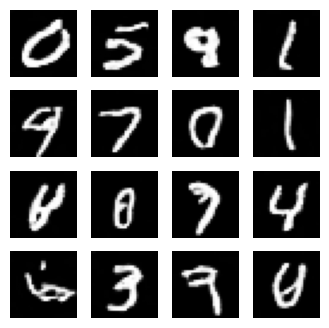

Epoch [54/100], Step [1/469], Discriminator Loss: 0.3209, Generator Loss: 3.4197
Epoch [54/100], Step [101/469], Discriminator Loss: 0.0930, Generator Loss: 3.5003
Epoch [54/100], Step [201/469], Discriminator Loss: 0.1802, Generator Loss: 4.1289
Epoch [54/100], Step [301/469], Discriminator Loss: 0.1683, Generator Loss: 2.9420
Epoch [54/100], Step [401/469], Discriminator Loss: 0.2166, Generator Loss: 3.4121


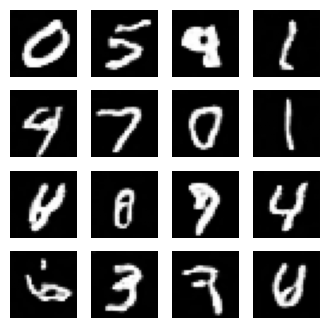

Epoch [55/100], Step [1/469], Discriminator Loss: 0.1752, Generator Loss: 3.3833
Epoch [55/100], Step [101/469], Discriminator Loss: 0.0385, Generator Loss: 4.2169
Epoch [55/100], Step [201/469], Discriminator Loss: 0.1150, Generator Loss: 4.1594
Epoch [55/100], Step [301/469], Discriminator Loss: 0.2351, Generator Loss: 2.9933
Epoch [55/100], Step [401/469], Discriminator Loss: 0.0834, Generator Loss: 4.4273


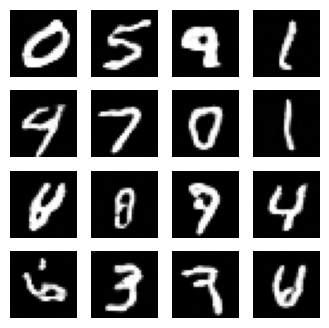

Epoch [56/100], Step [1/469], Discriminator Loss: 0.1569, Generator Loss: 3.7567
Epoch [56/100], Step [101/469], Discriminator Loss: 0.1035, Generator Loss: 3.8940
Epoch [56/100], Step [201/469], Discriminator Loss: 0.6351, Generator Loss: 1.3039
Epoch [56/100], Step [301/469], Discriminator Loss: 0.0607, Generator Loss: 6.3899
Epoch [56/100], Step [401/469], Discriminator Loss: 0.0575, Generator Loss: 4.2296


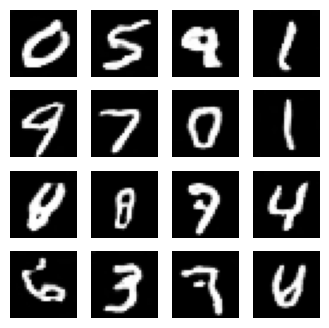

Epoch [57/100], Step [1/469], Discriminator Loss: 0.1873, Generator Loss: 4.0780
Epoch [57/100], Step [101/469], Discriminator Loss: 0.2298, Generator Loss: 4.5625
Epoch [57/100], Step [201/469], Discriminator Loss: 0.0570, Generator Loss: 5.3794
Epoch [57/100], Step [301/469], Discriminator Loss: 0.1095, Generator Loss: 3.8360
Epoch [57/100], Step [401/469], Discriminator Loss: 0.0413, Generator Loss: 5.4895


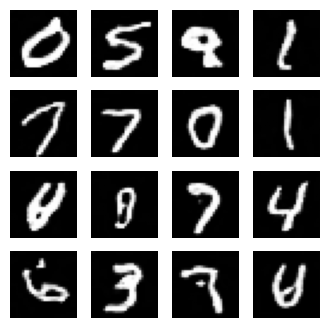

Epoch [58/100], Step [1/469], Discriminator Loss: 0.0859, Generator Loss: 4.5417
Epoch [58/100], Step [101/469], Discriminator Loss: 0.1289, Generator Loss: 4.6879
Epoch [58/100], Step [201/469], Discriminator Loss: 0.0694, Generator Loss: 3.6165
Epoch [58/100], Step [301/469], Discriminator Loss: 1.3943, Generator Loss: 0.2150
Epoch [58/100], Step [401/469], Discriminator Loss: 0.4949, Generator Loss: 4.7205


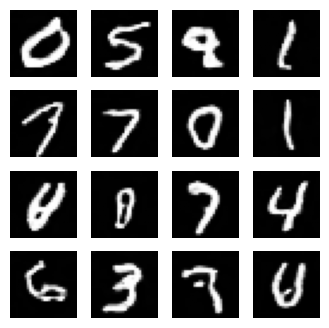

Epoch [59/100], Step [1/469], Discriminator Loss: 0.1532, Generator Loss: 3.5893
Epoch [59/100], Step [101/469], Discriminator Loss: 0.1895, Generator Loss: 4.4414
Epoch [59/100], Step [201/469], Discriminator Loss: 0.1807, Generator Loss: 3.2761
Epoch [59/100], Step [301/469], Discriminator Loss: 0.6301, Generator Loss: 4.0151
Epoch [59/100], Step [401/469], Discriminator Loss: 0.1763, Generator Loss: 3.4884


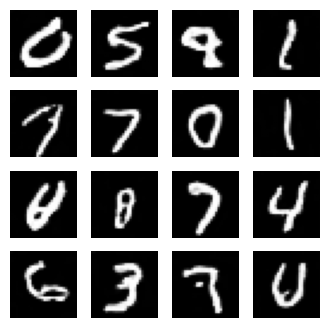

Epoch [60/100], Step [1/469], Discriminator Loss: 0.1535, Generator Loss: 3.0570
Epoch [60/100], Step [101/469], Discriminator Loss: 0.0989, Generator Loss: 4.2761
Epoch [60/100], Step [201/469], Discriminator Loss: 0.0481, Generator Loss: 4.8681
Epoch [60/100], Step [301/469], Discriminator Loss: 0.0449, Generator Loss: 5.5033
Epoch [60/100], Step [401/469], Discriminator Loss: 0.1459, Generator Loss: 3.6239


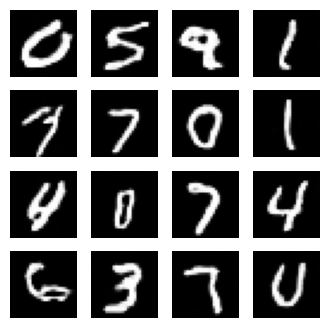

Epoch [61/100], Step [1/469], Discriminator Loss: 0.2131, Generator Loss: 3.4832
Epoch [61/100], Step [101/469], Discriminator Loss: 0.1625, Generator Loss: 4.4968
Epoch [61/100], Step [201/469], Discriminator Loss: 0.6610, Generator Loss: 6.5130
Epoch [61/100], Step [301/469], Discriminator Loss: 0.0409, Generator Loss: 4.8522
Epoch [61/100], Step [401/469], Discriminator Loss: 0.1136, Generator Loss: 3.9789


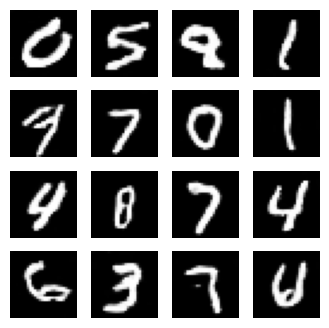

Epoch [62/100], Step [1/469], Discriminator Loss: 0.1489, Generator Loss: 3.5452
Epoch [62/100], Step [101/469], Discriminator Loss: 0.1684, Generator Loss: 4.8372
Epoch [62/100], Step [201/469], Discriminator Loss: 0.1934, Generator Loss: 3.7453
Epoch [62/100], Step [301/469], Discriminator Loss: 0.2246, Generator Loss: 5.0237
Epoch [62/100], Step [401/469], Discriminator Loss: 0.0887, Generator Loss: 3.9288


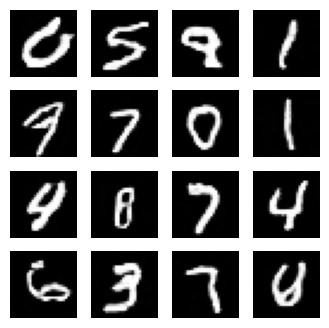

Epoch [63/100], Step [1/469], Discriminator Loss: 0.0488, Generator Loss: 3.0831
Epoch [63/100], Step [101/469], Discriminator Loss: 0.1445, Generator Loss: 3.3279
Epoch [63/100], Step [201/469], Discriminator Loss: 0.0827, Generator Loss: 4.2268
Epoch [63/100], Step [301/469], Discriminator Loss: 0.4577, Generator Loss: 1.6612
Epoch [63/100], Step [401/469], Discriminator Loss: 0.1593, Generator Loss: 2.9688


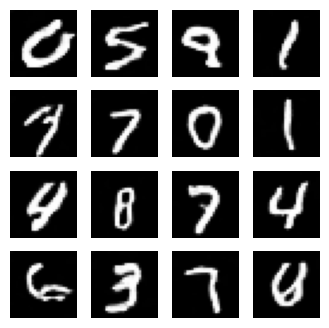

Epoch [64/100], Step [1/469], Discriminator Loss: 0.0447, Generator Loss: 4.4042
Epoch [64/100], Step [101/469], Discriminator Loss: 0.1271, Generator Loss: 2.9371
Epoch [64/100], Step [201/469], Discriminator Loss: 0.5255, Generator Loss: 0.9089
Epoch [64/100], Step [301/469], Discriminator Loss: 1.4768, Generator Loss: 11.4567
Epoch [64/100], Step [401/469], Discriminator Loss: 0.0529, Generator Loss: 4.5571


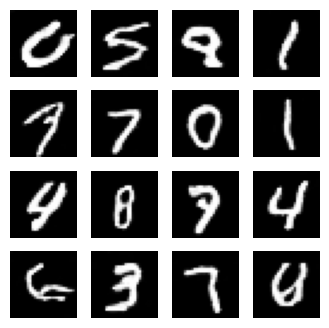

Epoch [65/100], Step [1/469], Discriminator Loss: 0.1224, Generator Loss: 3.5668
Epoch [65/100], Step [101/469], Discriminator Loss: 0.1703, Generator Loss: 4.8268
Epoch [65/100], Step [201/469], Discriminator Loss: 0.0635, Generator Loss: 4.3648
Epoch [65/100], Step [301/469], Discriminator Loss: 0.8532, Generator Loss: 6.6282
Epoch [65/100], Step [401/469], Discriminator Loss: 0.0788, Generator Loss: 5.0820


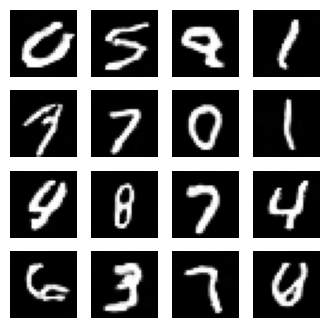

Epoch [66/100], Step [1/469], Discriminator Loss: 0.1350, Generator Loss: 3.4430
Epoch [66/100], Step [101/469], Discriminator Loss: 0.1168, Generator Loss: 3.7028
Epoch [66/100], Step [201/469], Discriminator Loss: 0.0464, Generator Loss: 5.4367
Epoch [66/100], Step [301/469], Discriminator Loss: 0.0476, Generator Loss: 3.9793
Epoch [66/100], Step [401/469], Discriminator Loss: 0.1853, Generator Loss: 3.0291


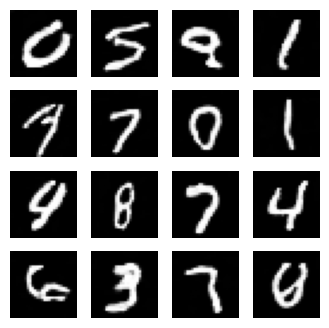

Epoch [67/100], Step [1/469], Discriminator Loss: 0.0813, Generator Loss: 3.7750
Epoch [67/100], Step [101/469], Discriminator Loss: 0.2726, Generator Loss: 4.9437
Epoch [67/100], Step [201/469], Discriminator Loss: 0.0588, Generator Loss: 4.8458
Epoch [67/100], Step [301/469], Discriminator Loss: 0.5650, Generator Loss: 7.8805
Epoch [67/100], Step [401/469], Discriminator Loss: 0.0473, Generator Loss: 6.5942


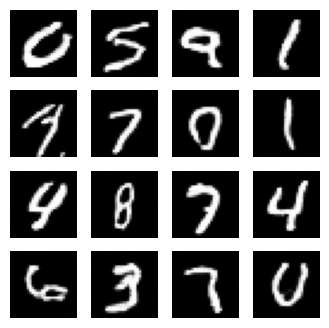

Epoch [68/100], Step [1/469], Discriminator Loss: 0.0424, Generator Loss: 3.9483
Epoch [68/100], Step [101/469], Discriminator Loss: 0.0739, Generator Loss: 4.2250
Epoch [68/100], Step [201/469], Discriminator Loss: 0.0365, Generator Loss: 4.7794
Epoch [68/100], Step [301/469], Discriminator Loss: 0.2397, Generator Loss: 3.6192
Epoch [68/100], Step [401/469], Discriminator Loss: 0.0534, Generator Loss: 5.0388


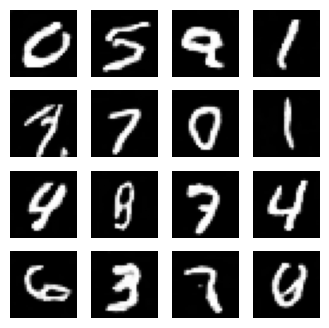

Epoch [69/100], Step [1/469], Discriminator Loss: 0.2137, Generator Loss: 4.9438
Epoch [69/100], Step [101/469], Discriminator Loss: 0.0848, Generator Loss: 4.1517
Epoch [69/100], Step [201/469], Discriminator Loss: 0.1596, Generator Loss: 3.2505
Epoch [69/100], Step [301/469], Discriminator Loss: 0.0526, Generator Loss: 4.3561
Epoch [69/100], Step [401/469], Discriminator Loss: 0.1827, Generator Loss: 3.1014


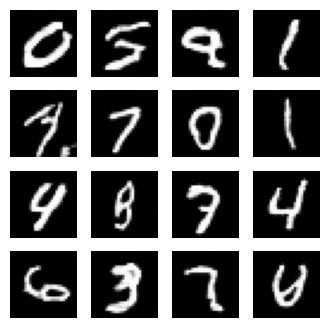

Epoch [70/100], Step [1/469], Discriminator Loss: 0.6544, Generator Loss: 5.9730
Epoch [70/100], Step [101/469], Discriminator Loss: 0.1658, Generator Loss: 3.4531
Epoch [70/100], Step [201/469], Discriminator Loss: 0.1760, Generator Loss: 3.0259
Epoch [70/100], Step [301/469], Discriminator Loss: 0.0974, Generator Loss: 4.4495
Epoch [70/100], Step [401/469], Discriminator Loss: 0.0781, Generator Loss: 4.3873


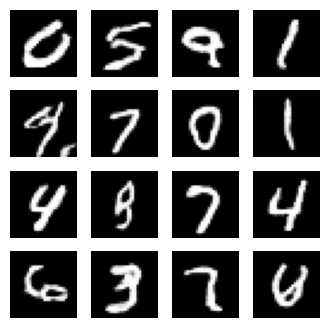

Epoch [71/100], Step [1/469], Discriminator Loss: 0.0618, Generator Loss: 4.2849
Epoch [71/100], Step [101/469], Discriminator Loss: 0.0953, Generator Loss: 3.8372
Epoch [71/100], Step [201/469], Discriminator Loss: 0.1795, Generator Loss: 3.1489
Epoch [71/100], Step [301/469], Discriminator Loss: 0.0902, Generator Loss: 5.5122
Epoch [71/100], Step [401/469], Discriminator Loss: 0.0848, Generator Loss: 2.7736


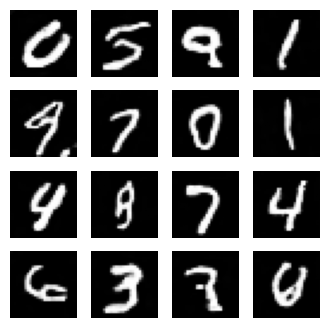

Epoch [72/100], Step [1/469], Discriminator Loss: 0.0463, Generator Loss: 5.0287
Epoch [72/100], Step [101/469], Discriminator Loss: 0.0968, Generator Loss: 4.1031
Epoch [72/100], Step [201/469], Discriminator Loss: 0.0691, Generator Loss: 4.7571
Epoch [72/100], Step [301/469], Discriminator Loss: 0.1976, Generator Loss: 1.5013
Epoch [72/100], Step [401/469], Discriminator Loss: 0.0640, Generator Loss: 5.0261


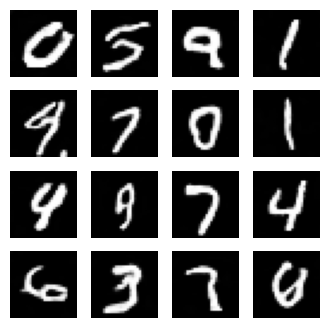

Epoch [73/100], Step [1/469], Discriminator Loss: 0.1125, Generator Loss: 4.1150
Epoch [73/100], Step [101/469], Discriminator Loss: 0.1330, Generator Loss: 3.8882
Epoch [73/100], Step [201/469], Discriminator Loss: 0.0228, Generator Loss: 4.6805
Epoch [73/100], Step [301/469], Discriminator Loss: 0.2453, Generator Loss: 2.1645
Epoch [73/100], Step [401/469], Discriminator Loss: 0.3579, Generator Loss: 4.8887


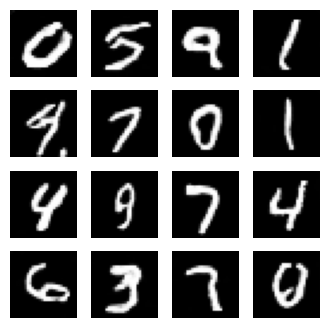

Epoch [74/100], Step [1/469], Discriminator Loss: 0.0518, Generator Loss: 5.4719
Epoch [74/100], Step [101/469], Discriminator Loss: 0.1830, Generator Loss: 3.7894
Epoch [74/100], Step [201/469], Discriminator Loss: 0.1871, Generator Loss: 3.3861
Epoch [74/100], Step [301/469], Discriminator Loss: 0.3877, Generator Loss: 1.0150
Epoch [74/100], Step [401/469], Discriminator Loss: 0.3363, Generator Loss: 6.2344


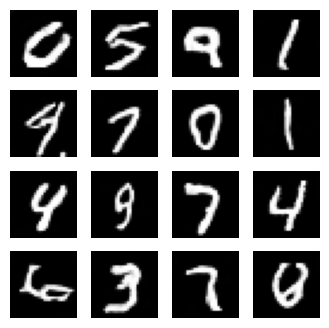

Epoch [75/100], Step [1/469], Discriminator Loss: 0.0871, Generator Loss: 4.4292
Epoch [75/100], Step [101/469], Discriminator Loss: 0.0475, Generator Loss: 4.7236
Epoch [75/100], Step [201/469], Discriminator Loss: 0.1927, Generator Loss: 3.1068
Epoch [75/100], Step [301/469], Discriminator Loss: 0.2634, Generator Loss: 2.7807
Epoch [75/100], Step [401/469], Discriminator Loss: 0.0348, Generator Loss: 5.0307


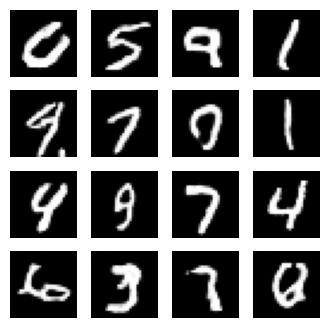

Epoch [76/100], Step [1/469], Discriminator Loss: 0.0231, Generator Loss: 6.3109
Epoch [76/100], Step [101/469], Discriminator Loss: 0.0327, Generator Loss: 4.8940
Epoch [76/100], Step [201/469], Discriminator Loss: 0.0665, Generator Loss: 4.7671
Epoch [76/100], Step [301/469], Discriminator Loss: 0.0517, Generator Loss: 5.3275
Epoch [76/100], Step [401/469], Discriminator Loss: 0.0602, Generator Loss: 4.1734


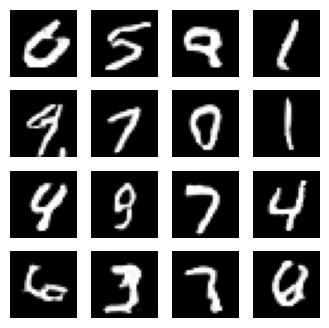

Epoch [77/100], Step [1/469], Discriminator Loss: 0.1803, Generator Loss: 2.7980
Epoch [77/100], Step [101/469], Discriminator Loss: 0.1023, Generator Loss: 4.7958
Epoch [77/100], Step [201/469], Discriminator Loss: 0.8919, Generator Loss: 7.2367
Epoch [77/100], Step [301/469], Discriminator Loss: 0.1824, Generator Loss: 3.6858
Epoch [77/100], Step [401/469], Discriminator Loss: 0.1350, Generator Loss: 3.3056


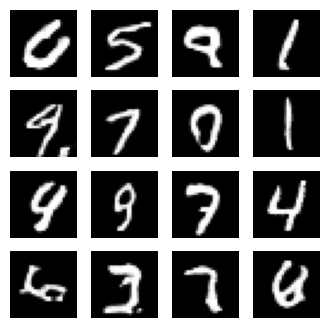

Epoch [78/100], Step [1/469], Discriminator Loss: 0.0813, Generator Loss: 4.3876
Epoch [78/100], Step [101/469], Discriminator Loss: 0.0343, Generator Loss: 6.8659
Epoch [78/100], Step [201/469], Discriminator Loss: 0.0973, Generator Loss: 4.3739
Epoch [78/100], Step [301/469], Discriminator Loss: 0.0331, Generator Loss: 5.3161
Epoch [78/100], Step [401/469], Discriminator Loss: 1.8432, Generator Loss: 0.6306


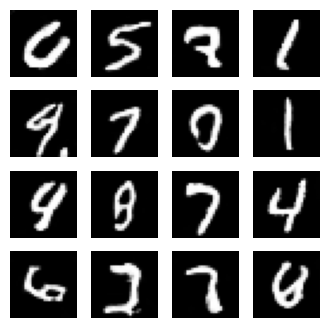

Epoch [79/100], Step [1/469], Discriminator Loss: 0.0688, Generator Loss: 6.3104
Epoch [79/100], Step [101/469], Discriminator Loss: 0.2375, Generator Loss: 3.2247
Epoch [79/100], Step [201/469], Discriminator Loss: 0.0642, Generator Loss: 4.7887
Epoch [79/100], Step [301/469], Discriminator Loss: 0.0942, Generator Loss: 4.0569
Epoch [79/100], Step [401/469], Discriminator Loss: 0.1424, Generator Loss: 2.7690


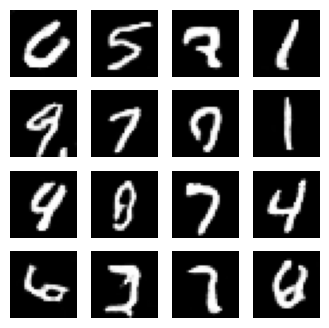

Epoch [80/100], Step [1/469], Discriminator Loss: 0.1156, Generator Loss: 4.6893
Epoch [80/100], Step [101/469], Discriminator Loss: 0.0497, Generator Loss: 4.6117
Epoch [80/100], Step [201/469], Discriminator Loss: 0.0772, Generator Loss: 4.8702
Epoch [80/100], Step [301/469], Discriminator Loss: 0.0402, Generator Loss: 4.4891
Epoch [80/100], Step [401/469], Discriminator Loss: 0.0627, Generator Loss: 6.3464


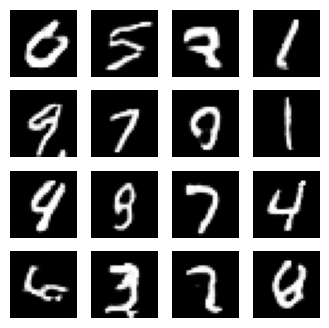

Epoch [81/100], Step [1/469], Discriminator Loss: 0.1433, Generator Loss: 4.6452
Epoch [81/100], Step [101/469], Discriminator Loss: 0.0584, Generator Loss: 3.4227
Epoch [81/100], Step [201/469], Discriminator Loss: 0.1932, Generator Loss: 3.4215
Epoch [81/100], Step [301/469], Discriminator Loss: 0.0485, Generator Loss: 7.6758
Epoch [81/100], Step [401/469], Discriminator Loss: 0.1135, Generator Loss: 4.6091


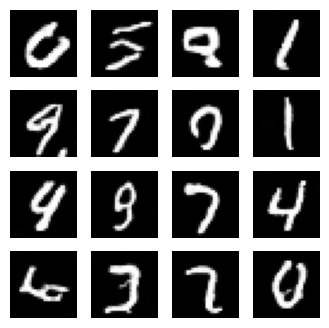

Epoch [82/100], Step [1/469], Discriminator Loss: 0.0822, Generator Loss: 4.3887
Epoch [82/100], Step [101/469], Discriminator Loss: 4.2091, Generator Loss: 11.6379
Epoch [82/100], Step [201/469], Discriminator Loss: 0.1347, Generator Loss: 4.7087
Epoch [82/100], Step [301/469], Discriminator Loss: 0.1288, Generator Loss: 4.3277
Epoch [82/100], Step [401/469], Discriminator Loss: 0.1437, Generator Loss: 4.2320


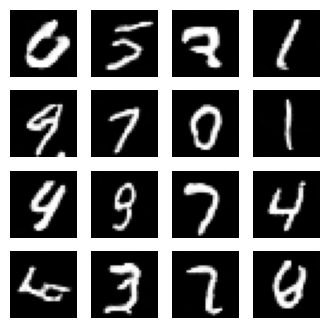

Epoch [83/100], Step [1/469], Discriminator Loss: 0.1819, Generator Loss: 5.4831
Epoch [83/100], Step [101/469], Discriminator Loss: 0.0383, Generator Loss: 5.3266
Epoch [83/100], Step [201/469], Discriminator Loss: 0.0953, Generator Loss: 4.4312
Epoch [83/100], Step [301/469], Discriminator Loss: 0.0933, Generator Loss: 3.1680
Epoch [83/100], Step [401/469], Discriminator Loss: 0.0910, Generator Loss: 2.9948


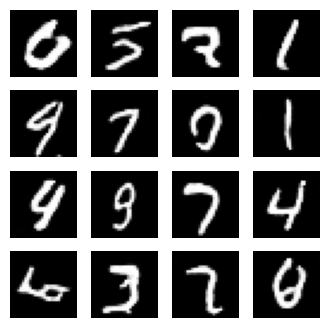

Epoch [84/100], Step [1/469], Discriminator Loss: 0.5728, Generator Loss: 3.4586
Epoch [84/100], Step [101/469], Discriminator Loss: 0.0513, Generator Loss: 5.7697
Epoch [84/100], Step [201/469], Discriminator Loss: 0.0546, Generator Loss: 5.1701
Epoch [84/100], Step [301/469], Discriminator Loss: 0.0538, Generator Loss: 5.5517
Epoch [84/100], Step [401/469], Discriminator Loss: 0.3932, Generator Loss: 6.5883


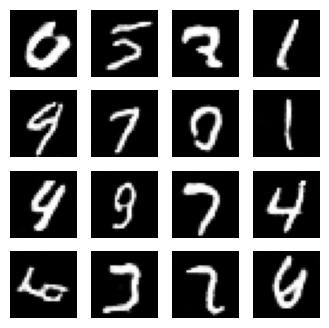

Epoch [85/100], Step [1/469], Discriminator Loss: 0.0217, Generator Loss: 6.0463
Epoch [85/100], Step [101/469], Discriminator Loss: 0.0719, Generator Loss: 3.8111
Epoch [85/100], Step [201/469], Discriminator Loss: 0.0462, Generator Loss: 7.1925
Epoch [85/100], Step [301/469], Discriminator Loss: 0.0739, Generator Loss: 4.2903
Epoch [85/100], Step [401/469], Discriminator Loss: 0.1302, Generator Loss: 4.4137


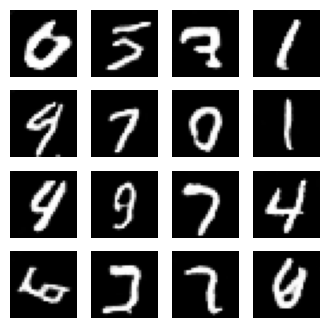

Epoch [86/100], Step [1/469], Discriminator Loss: 0.0871, Generator Loss: 4.3881
Epoch [86/100], Step [101/469], Discriminator Loss: 0.2987, Generator Loss: 3.8006
Epoch [86/100], Step [201/469], Discriminator Loss: 0.0470, Generator Loss: 4.9291
Epoch [86/100], Step [301/469], Discriminator Loss: 0.1720, Generator Loss: 4.2719
Epoch [86/100], Step [401/469], Discriminator Loss: 0.0293, Generator Loss: 5.2781


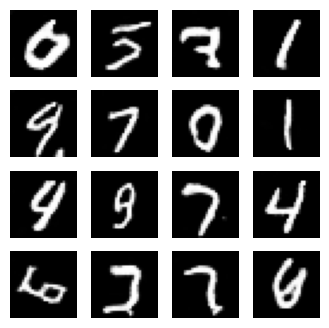

Epoch [87/100], Step [1/469], Discriminator Loss: 0.1260, Generator Loss: 3.5538
Epoch [87/100], Step [101/469], Discriminator Loss: 0.1897, Generator Loss: 3.3491
Epoch [87/100], Step [201/469], Discriminator Loss: 0.2696, Generator Loss: 6.0203
Epoch [87/100], Step [301/469], Discriminator Loss: 0.0775, Generator Loss: 5.0499
Epoch [87/100], Step [401/469], Discriminator Loss: 0.0431, Generator Loss: 4.5712


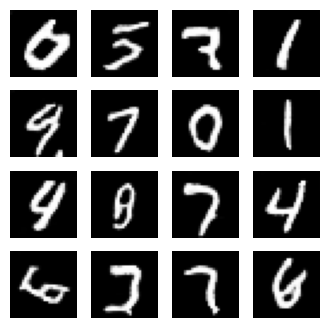

Epoch [88/100], Step [1/469], Discriminator Loss: 0.4603, Generator Loss: 5.6038
Epoch [88/100], Step [101/469], Discriminator Loss: 0.2022, Generator Loss: 3.8345
Epoch [88/100], Step [201/469], Discriminator Loss: 0.0674, Generator Loss: 4.8180
Epoch [88/100], Step [301/469], Discriminator Loss: 0.0910, Generator Loss: 4.3804
Epoch [88/100], Step [401/469], Discriminator Loss: 0.2779, Generator Loss: 4.2186


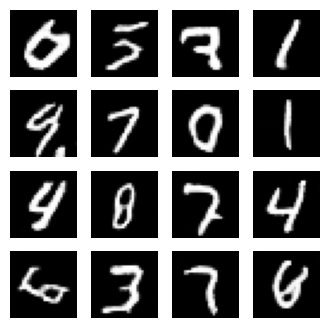

Epoch [89/100], Step [1/469], Discriminator Loss: 0.1323, Generator Loss: 3.2142
Epoch [89/100], Step [101/469], Discriminator Loss: 0.1933, Generator Loss: 5.1380
Epoch [89/100], Step [201/469], Discriminator Loss: 0.0594, Generator Loss: 5.0667
Epoch [89/100], Step [301/469], Discriminator Loss: 0.1844, Generator Loss: 3.2119
Epoch [89/100], Step [401/469], Discriminator Loss: 0.2624, Generator Loss: 3.2750


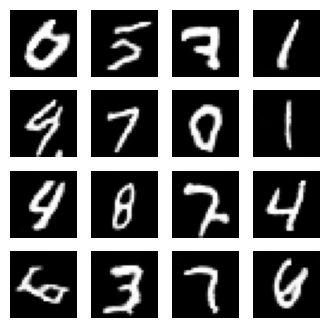

Epoch [90/100], Step [1/469], Discriminator Loss: 0.5860, Generator Loss: 7.3285
Epoch [90/100], Step [101/469], Discriminator Loss: 0.0997, Generator Loss: 4.3561
Epoch [90/100], Step [201/469], Discriminator Loss: 0.0483, Generator Loss: 5.0974
Epoch [90/100], Step [301/469], Discriminator Loss: 0.0701, Generator Loss: 7.5112
Epoch [90/100], Step [401/469], Discriminator Loss: 0.1060, Generator Loss: 2.5141


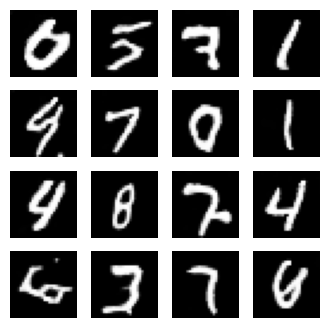

Epoch [91/100], Step [1/469], Discriminator Loss: 0.1418, Generator Loss: 4.4328
Epoch [91/100], Step [101/469], Discriminator Loss: 0.1165, Generator Loss: 4.2169
Epoch [91/100], Step [201/469], Discriminator Loss: 0.0694, Generator Loss: 4.1250
Epoch [91/100], Step [301/469], Discriminator Loss: 0.0847, Generator Loss: 4.4092
Epoch [91/100], Step [401/469], Discriminator Loss: 0.1305, Generator Loss: 4.8078


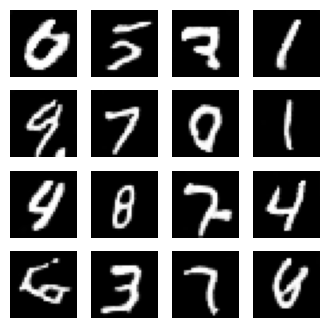

Epoch [92/100], Step [1/469], Discriminator Loss: 0.0417, Generator Loss: 7.6417
Epoch [92/100], Step [101/469], Discriminator Loss: 0.1045, Generator Loss: 3.5555
Epoch [92/100], Step [201/469], Discriminator Loss: 0.0577, Generator Loss: 8.9158
Epoch [92/100], Step [301/469], Discriminator Loss: 0.0393, Generator Loss: 3.4575
Epoch [92/100], Step [401/469], Discriminator Loss: 0.1318, Generator Loss: 4.1235


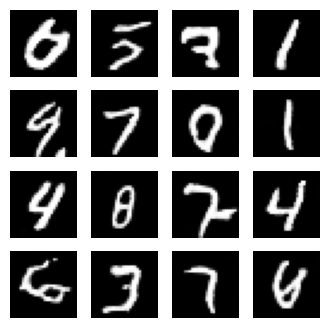

Epoch [93/100], Step [1/469], Discriminator Loss: 0.0969, Generator Loss: 4.8486
Epoch [93/100], Step [101/469], Discriminator Loss: 0.0930, Generator Loss: 4.6077
Epoch [93/100], Step [201/469], Discriminator Loss: 0.0452, Generator Loss: 4.2783
Epoch [93/100], Step [301/469], Discriminator Loss: 0.2225, Generator Loss: 3.1164
Epoch [93/100], Step [401/469], Discriminator Loss: 0.1004, Generator Loss: 4.3891


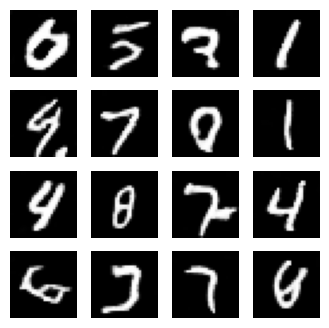

Epoch [94/100], Step [1/469], Discriminator Loss: 0.0540, Generator Loss: 4.7064
Epoch [94/100], Step [101/469], Discriminator Loss: 0.1254, Generator Loss: 3.9042
Epoch [94/100], Step [201/469], Discriminator Loss: 0.0400, Generator Loss: 5.3110
Epoch [94/100], Step [301/469], Discriminator Loss: 0.0332, Generator Loss: 7.0171
Epoch [94/100], Step [401/469], Discriminator Loss: 0.0059, Generator Loss: 6.4821


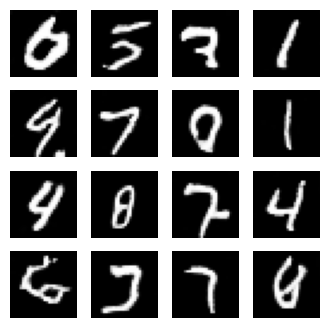

Epoch [95/100], Step [1/469], Discriminator Loss: 0.4655, Generator Loss: 5.1500
Epoch [95/100], Step [101/469], Discriminator Loss: 0.0784, Generator Loss: 5.6559
Epoch [95/100], Step [201/469], Discriminator Loss: 0.0667, Generator Loss: 2.9741
Epoch [95/100], Step [301/469], Discriminator Loss: 0.0380, Generator Loss: 5.0994
Epoch [95/100], Step [401/469], Discriminator Loss: 0.0424, Generator Loss: 5.2190


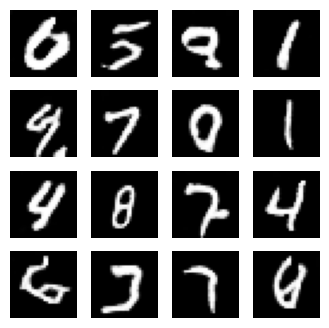

Epoch [96/100], Step [1/469], Discriminator Loss: 0.1419, Generator Loss: 3.5130
Epoch [96/100], Step [101/469], Discriminator Loss: 0.0205, Generator Loss: 6.0297
Epoch [96/100], Step [201/469], Discriminator Loss: 0.1479, Generator Loss: 3.5889
Epoch [96/100], Step [301/469], Discriminator Loss: 0.1747, Generator Loss: 4.7683
Epoch [96/100], Step [401/469], Discriminator Loss: 0.1170, Generator Loss: 3.6197


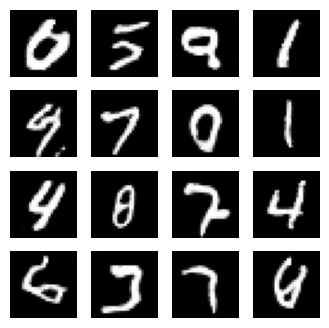

Epoch [97/100], Step [1/469], Discriminator Loss: 0.0599, Generator Loss: 6.1871
Epoch [97/100], Step [101/469], Discriminator Loss: 0.1339, Generator Loss: 4.4812
Epoch [97/100], Step [201/469], Discriminator Loss: 0.0437, Generator Loss: 2.2427
Epoch [97/100], Step [301/469], Discriminator Loss: 0.0408, Generator Loss: 5.1542
Epoch [97/100], Step [401/469], Discriminator Loss: 0.0438, Generator Loss: 4.9946


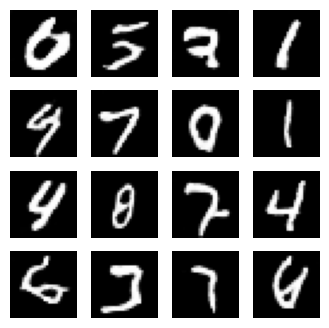

Epoch [98/100], Step [1/469], Discriminator Loss: 0.0474, Generator Loss: 3.7701
Epoch [98/100], Step [101/469], Discriminator Loss: 0.1811, Generator Loss: 3.6011
Epoch [98/100], Step [201/469], Discriminator Loss: 0.0277, Generator Loss: 6.5415
Epoch [98/100], Step [301/469], Discriminator Loss: 0.3246, Generator Loss: 7.4572
Epoch [98/100], Step [401/469], Discriminator Loss: 0.0279, Generator Loss: 7.4847


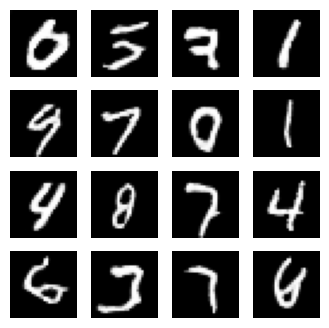

Epoch [99/100], Step [1/469], Discriminator Loss: 0.0992, Generator Loss: 4.9765
Epoch [99/100], Step [101/469], Discriminator Loss: 0.1127, Generator Loss: 4.7417
Epoch [99/100], Step [201/469], Discriminator Loss: 0.0607, Generator Loss: 4.5663
Epoch [99/100], Step [301/469], Discriminator Loss: 0.0936, Generator Loss: 4.6745
Epoch [99/100], Step [401/469], Discriminator Loss: 0.0919, Generator Loss: 4.5262


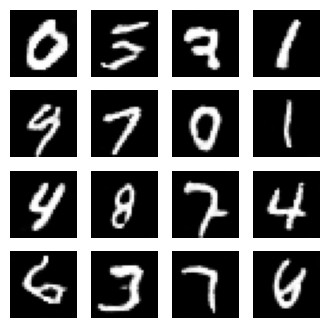

Epoch [100/100], Step [1/469], Discriminator Loss: 0.1029, Generator Loss: 3.8173
Epoch [100/100], Step [101/469], Discriminator Loss: 0.2528, Generator Loss: 6.6754
Epoch [100/100], Step [201/469], Discriminator Loss: 0.0906, Generator Loss: 3.4773
Epoch [100/100], Step [301/469], Discriminator Loss: 0.0356, Generator Loss: 5.0773
Epoch [100/100], Step [401/469], Discriminator Loss: 0.0498, Generator Loss: 4.8390


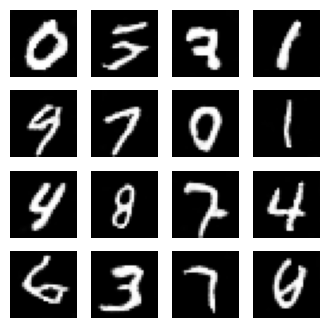

In [15]:
for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(train_loader):
        real, _ = data
        real = real.to(device)
        z = torch.randn(BATCH_SIZE, NOISE_DIM).to(device)

        fake = gen(z)
        disc_real = disc(real).view(-1)
        disc_fake = disc(fake.detach()).view(-1)
        disc_loss = (criterion(disc_real, torch.ones_like(disc_real, device=device)) +
                     criterion(disc_fake, torch.zeros_like(disc_fake, device=device)))

        opt_disc.zero_grad()
        disc_loss.backward()
        opt_disc.step()

        output = disc(fake).view(-1)
        gen_loss = criterion(output, torch.ones_like(output))

        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()

        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], '
                  f'Discriminator Loss: {disc_loss:.4f}, '
                  f'Generator Loss: {gen_loss.item():.4f}')

    generate_and_save_images(gen, epoch, test_noise)


In [ ]:
torch.save(gen.cpu(), 'stylegen100.pth')
torch.save(disc.cpu(), 'styledisc100.pth')

In [11]:
import torch

gen2 = torch.load('stylegen100.pth', weights_only=False).to(device)
disc2 = torch.load('styledisc100.pth', weights_only=False).to(device)

In [18]:
!zip -r ./gan2.zip ./gan

from google.colab import files
files.download("./gan2.zip")

updating: gan/ (stored 0%)
updating: gan/image_at_epoch_0046.png (deflated 8%)
updating: gan/image_at_epoch_0009.png (deflated 5%)
updating: gan/image_at_epoch_0017.png (deflated 6%)
updating: gan/image_at_epoch_0004.png (deflated 5%)
updating: gan/image_at_epoch_0005.png (deflated 5%)
updating: gan/image_at_epoch_0015.png (deflated 6%)
updating: gan/image_at_epoch_0023.png (deflated 7%)
updating: gan/image_at_epoch_0001.png (deflated 5%)
updating: gan/image_at_epoch_0100.png (deflated 9%)
updating: gan/image_at_epoch_0076.png (deflated 10%)
updating: gan/image_at_epoch_0097.png (deflated 10%)
updating: gan/image_at_epoch_0011.png (deflated 5%)
updating: gan/image_at_epoch_0054.png (deflated 8%)
updating: gan/image_at_epoch_0060.png (deflated 9%)
updating: gan/image_at_epoch_0065.png (deflated 8%)
updating: gan/image_at_epoch_0026.png (deflated 7%)
updating: gan/image_at_epoch_0025.png (deflated 7%)
updating: gan/image_at_epoch_0092.png (deflated 9%)
updating: gan/image_at_epoch_0039.p

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

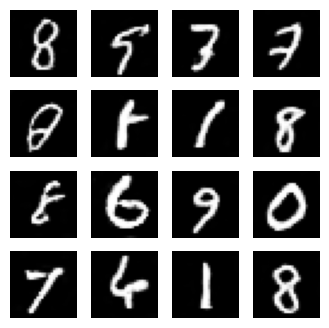

In [18]:
# Генерация тестовых изображений в конце обучения
test_noise = torch.randn(16, NOISE_DIM, device=device)
generate_and_save_images(gen2, 200, test_noise)

In [4]:
import cv2
import os


image_folder = 'gan'
video_name = 'output_video.mp4'
fps = 15

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images.sort()

frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

# Домашка (дедлайн 20.06)

отправлять в тг: @anna_getun, если будут вопросы, также можно писать

Задача: модицифировать код с использованием рассмотренных в лекции методов (DCGAN, Conditional GAN, StyleGAN).
- Достаточно использование одной модели на выбор
- Можно использовать другие датасеты на выбор
- Увеличить параметры (Epoch, batch) для улучшения качества картинок (**обязательно**)

**Пример**

- DCGAN - поиграться со слоями в генераторе

- Сonditional GAN - создать функцию для генерации изображений заданного(-ых) класса(-ов)

- StyleGAN  - добавление шума на всех слоях, модификация генератора и дискриминатора


*не обязательно использовать данный код, можно создать свою собственную модель GAN и модифицировать её

